In [1]:
import sys

In [2]:
!{sys.executable} -m pip install seaborn joblib "gymnasium[atari]" "gymnasium[accept-rom-license]" matplotlib scikit-image

In [3]:
available = [
    'Adventure',
    'AirRaid',
    'Alien',
    'Amidar',
    'Assault',
    'Asterix',
    'Asteroids',
    'Atlantis',
    'Atlantis2',
    'Backgammon',
    'BankHeist',
    'BasicMath',
    'BattleZone',
    'BeamRider',
    'Berzerk',
    'Blackjack',
    'Bowling',
    'Boxing',
    'Breakout',
    'CMakeLists',
    'Carnival',
    'Casino',
    'Centipede',
    'ChopperCommand',
    'CrazyClimber',
    'Crossbow',
    'DarkChambers',
    'Defender',
    'DemonAttack',
    'DonkeyKong',
    'DoubleDunk',
    'Earthworld',
    'ElevatorAction',
    'Enduro',
    'Entombed',
    'Et',
    'FishingDerby',
    'FlagCapture',
    'Freeway',
    'Frogger',
    'Frostbite',
    'Galaxian',
    'Gopher',
    'Gravitar',
    'Hangman',
    'HauntedHouse',
    'Hero',
    'HumanCannonball',
    'IceHockey',
    'JamesBond',
    'JourneyEscape',
    'Kaboom',
    'Kangaroo',
    'KeystoneKapers',
    'Kingkong',
    'Klax',
    'Koolaid',
    'Krull',
    'KungFuMaster',
    'LaserGates',
    'LostLuggage',
    'MarioBros',
    'MiniatureGolf',
    'MontezumaRevenge',
    'MrDo',
    'MsPacman',
    'NameThisGame',
    'Othello',
    'Pacman',
    'Phoenix',
    'Pitfall',
    'Pitfall2',
    'Pong',
    'Pooyan',
    'PrivateEye',
    'QBert',
    'RiverRaid',
    'RoadRunner',
    'RoboTank',
    'Seaquest',
    'SirLancelot',
    'Skiing',
    'Solaris',
    'SpaceInvaders',
    'SpaceWar',
    'StarGunner',
    'Superman',
    'Surround',
    'Tennis',
    'Tetris',
    'TicTacToe3d',
    'TimePilot',
    'Trondead',
    'Turmoil',
    'Tutankham',
    'UpNDown',
    'Venture',
    'VideoCheckers',
    'VideoChess',
    'VideoCube',
    'VideoPinball',
    'WizardOfWor',
    'WordZapper',
    'YarsRevenge',
    'Zaxxon'
 ]

In [4]:
import gymnasium as gym

seed = 0
env_names = [
    f"ALE/{name}-v5"
    for name in available
]
envs = {}
i = 0
for name in env_names:
    try:
        envs[f'{name}_{i}'] = gym.make(name)
    except:
        try:
            envs[f'{name}_{i}'] = gym.make(name.capitalize())
        except:
            pass

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
len(envs)

97

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

In [7]:
input_shape = (210, 160, 3)
exclude_env = []
observation = None
for env_name, env in envs.items():
    observation, _ = env.reset(seed=seed)
    if observation.shape != input_shape:
        exclude_env.append(env_name)
        continue
    
for env_name in exclude_env:
    del envs[env_name]

In [8]:
len(envs)

85

In [9]:
all_names = '_'.join(
    [name.split('/')[-1].split('-')[0][:3] for name in envs.keys()]
)
all_names = f'Atari_{len(envs.keys())}_games'
all_names

'Atari_85_games'

In [46]:
encoder_alpha = 0.4

In [47]:
weights_name = f"{all_names}_autoencoder_{encoder_alpha}.state_dict"
weights_name

'Atari_85_games_autoencoder_0.4.state_dict'

In [10]:
from skimage.transform import rescale, resize, downscale_local_mean

def resize_frame(frame):
    image_resized = downscale_local_mean(frame, (6, 4, 1))
    return image_resized.astype(int)
    
image_downscaled = resize_frame(observation)
input_shape = image_downscaled.shape
input_shape

(35, 40, 3)

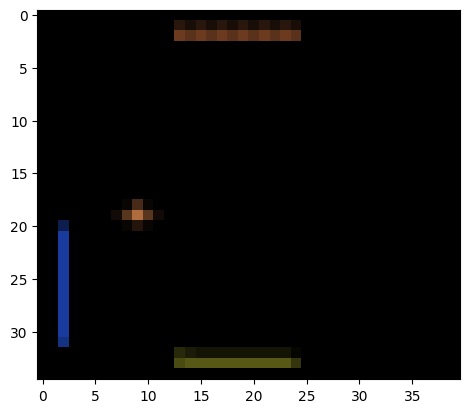

In [11]:
plt.imshow(image_downscaled)

In [16]:
import os

os.chdir('atari-autoencoder')

In [17]:
import joblib

preprocess_constants = joblib.load('preprocess_constants.joblib')
preprocess_constants

{'preprocess_mean': 2.9275974254729795e-05,
 'preprocess_std': 0.017280908223757496}

In [52]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from skimage.transform import downscale_local_mean


class AtariEncoder(nn.Module):
    conv_num_filters = 64
    filter_size = 3
    pool_size = 2
    encode_size = 128
    dense_mid_size = 512
    bottleneck_size = (4, 5)
    def __init__(self, debug=False):
        super(AtariEncoder, self).__init__()
        self.debug = debug
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Flatten(),
            nn.Linear(self.conv_num_filters * self.bottleneck_size[0] * self.bottleneck_size[1], self.dense_mid_size),
            nn.ReLU(True),
            nn.Linear(self.dense_mid_size, self.encode_size),
            nn.ReLU(True)
        )

    def forward(self, x):
        print(x.shape)
        x = x.movedim(-1, 1)
        print(x.shape)
        for layer in self.encoder.children():
            x = layer(x)
            if self.debug:
                print(x.shape)
        return x

class AtariEncodingEnv(gym.ObservationWrapper):
    def __init__(self, env, encoder, resize_shape, alpha, preprocess_mean, preprocess_std, device='cpu'):
        super().__init__(env)
        self.resize_shape = resize_shape
        self.alpha = alpha
        self.encoder = encoder
        self.preprocess_mean = preprocess_mean
        self.preprocess_std = preprocess_std
        self.delta = None
        self.device = device

    def observation(self, observation):
        observation = self.resize_frame(observation)
        if self.delta is None:
            self.delta = np.zeros(observation.shape)
        else:
            delta_now = observation / 255.0 - self.delta / 255.0
            self.delta = self.alpha * delta_now + (1 - self.alpha) * self.delta

        if self.preprocess_mean is None:
            self.preprocess_mean = np.mean(self.delta)
        if self.preprocess_std is None:
            self.preprocess_std = np.std(self.delta)

        self.delta = self.preprocess_images(self.delta, self.preprocess_mean, self.preprocess_std)
        
        # Encoding the delta
        delta_tensor = torch.tensor(self.delta, dtype=torch.float32).unsqueeze(0).to(self.device)
        print(delta_tensor.shape)
        self.delta = self.encoder(delta_tensor).squeeze(0).detach().numpy()

        return self.delta

    def reset(self, **kwargs):
        self.delta = None
        observation, info = self.env.reset(**kwargs)
        return self.observation(observation), info

    def resize_frame(self, frame):
        # resizing image with downscale_local_mean
        return downscale_local_mean(frame, self.resize_shape).astype(int)

    def preprocess_images(self, images, mean, std):
        return (images - mean) / std

    def load_encoder_weights(self, weights_path):
        state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
        state_dict = {
            k: v for k, v in state_dict.items() if k in self.encoder.state_dict()
        }
        self.encoder.load_state_dict(state_dict)

env = AtariEncodingEnv(envs['ALE/Pong-v5_0'], AtariEncoder(debug=False), (6, 4, 1), alpha=encoder_alpha, **preprocess_constants)
env.load_encoder_weights(weights_name)
env.reset()

torch.Size([1, 35, 40, 3])
torch.Size([1, 35, 40, 3])
torch.Size([1, 3, 35, 40])


(array([1.0365137 , 1.2566333 , 0.8866816 , 0.7404944 , 0.9707567 ,
        0.89127326, 0.7051216 , 1.0133883 , 0.75960904, 0.933888  ,
        0.9059419 , 0.8934258 , 0.72368383, 1.2758784 , 1.7360692 ,
        1.1025834 , 0.91349316, 0.8501614 , 0.82555175, 0.9984979 ,
        0.74912995, 1.2360104 , 1.04519   , 0.9471506 , 0.73810583,
        0.8546157 , 0.9577163 , 0.6411437 , 0.72363186, 0.54056287,
        1.0652182 , 1.3563408 , 1.1173449 , 1.092219  , 1.2374878 ,
        1.0008802 , 1.0023956 , 0.9504629 , 0.        , 1.0086684 ,
        0.88721967, 0.934907  , 0.9158432 , 0.5115538 , 0.86898863,
        1.0873687 , 0.811849  , 0.96731365, 0.9512297 , 0.9880392 ,
        1.0719129 , 0.81830984, 1.0787143 , 0.        , 0.76009774,
        1.1120634 , 0.98145   , 1.2574557 , 0.72057277, 0.8855164 ,
        1.1390021 , 0.37009037, 1.2607502 , 0.9926627 , 0.84077454,
        1.0299811 , 1.0815989 , 1.7388374 , 1.2687855 , 1.2439147 ,
        1.1163883 , 1.1850353 , 0.7165136 , 1.14